# Assignment 3 - Supervised classification applied on traffic data 
<hr>

Traffic congestion is everywhere. Here, we provide three different perspectives of a congestion - traveler's, traffic at a given moment mapped on a GIS map and in the form of a space-time speed map (space-time map is explained in the video). 
<img src="traffic jam.png">

There are different kinds of traffic congestions, which could be attributed to different causes. For example, if somebody makes a sudden break at a highway, it can create the first pattern given below whereas the second pattern is the congestion caused because of a huge fire near the Schipol tunnel in 2017.
<img src="examples.png">

Thus, if we can group these different types of congestion and add context to these groups, we can use it for diagnostic and prediction purposes. For eg. if all the patterns in a group are caused by heavy rainfall, we can classify them. Thus, given the current traffic state and the weather, we can predict how the congestion will evolve and hence mitigate them. But for this, we first need to classify. In literature, the congestion are mainly categorised into 6 groups and hence the data is also manually classified into these 6 classes. And you are going to build a classifier for these congestion types in this assignment.

## Data


The speed and flow data is collected from the A13 highway corridor in the Netherlands using loop detectors for the months of October from 2012 to 2020. We estimate the travel time for the corridor from speed and flow. The speed and flow data has been used during the course and for the assignment, you will be working with the travel time. The structure of the pandas dataframe is as follows:

- **id**: pattern id
- **date**: measurement date
- **speed**: speed matrix of size space X time, speed is measured every 30 seconds
- **flow**: flow matrix of size space X time, flow is measured every 30 seconds
- **space**: relative distance of the highway corridor sampled every 200 meters
- **time**: measurement time resolution of speed and flow
- **travel_time**: estimated travel time of the corridor at specific time
- **travel_time_time**: time resolution of estimated travel time
- **label**: manually classified label of the congestion patterns

The relevant features are date, travel_time, travel_time_time, label

NOTE: The manual classification was done based on the speed matrix. The time aggregation of the travel time data is different from the aggregation of the speed and flow data. Account for this if you use speed and flow for your analysis.

<img src="input.png">

## Instruction

The tasks are defined in each section. 
- Implement the solutions using code cells and write your analysis using markdown cells. 
- Once you have completed everything, remember to restart the kernel and run all cells again. Make sure there are no errors. 
- Save the notebook (replace XX in the filename with your group number). 
- Export a HTML version of the notebook. Hint: Menu -> File -> Download as -> HTML. 
- Submit both the notebook (.ipynb) and the export (.html)

## Justify all you answers with code or visualisations or numbers! Max 200 words per answer!

<hr>

In [1]:
#all library imports
%matplotlib inline
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2

Text(0.5, 1.0, 'Travel Time')

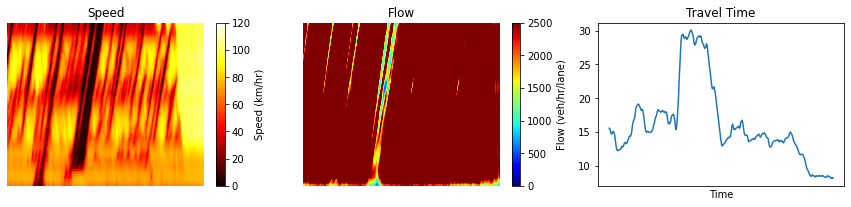

In [2]:
#Reading the input and some visualisation code
dataset = pd.read_pickle('Assignment3_dataset_october')
fig, ax = plt.subplots(1,3, figsize=(15,3))
index = 0

im = ax[0].imshow(dataset.iloc[index].speed, cmap=plt.get_cmap('hot'), aspect="auto", vmin=0, vmax=120)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Speed (km/hr)', rotation=90)
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[0].axis('off')
ax[0].set_title('Speed')

im = ax[1].imshow(dataset.iloc[index].flow, cmap=plt.get_cmap('jet'), aspect="auto", vmin=0, vmax=2500)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Flow (veh/hr/lane)', rotation=90)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[1].axis('off')
ax[1].set_title('Flow')

im = ax[2].plot(dataset.iloc[index].travel_time_time, dataset.iloc[index].travel_time)
ax[2].set_xticks([])
ax[2].set_xlabel('Time')
ax[2].set_title('Travel Time')

## Task 1 - Data Preprocessing

QUESTION 1: Is the raw travel time sufficient to distinguish between the six classes?
Hint: Use TSNE or LDA

[Text(0.5, 1.0, 'LDA')]

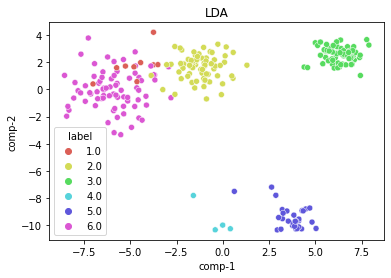

In [6]:
#Code
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
# raw data as feature
dataset['raw_speed'] = dataset['speed'].to_numpy().flatten()
dataset['raw_flow'] = dataset['flow'].to_numpy().flatten()
dataset['raw_travel_time'] = dataset['travel_time'].to_numpy().flatten()
data = dataset['raw_travel_time'][:]

i = 0
final_data = np.zeros((np.size(data), np.size(data[0])))
while i < np.size(data):
    temp = []
    temp = np.array(data[i][:]).reshape(-1,1)
    #print(len(temp))
    if len(temp) < np.size(data[0]):
        add1 = temp #np.array(data[i][:])
        add2 = np.zeros((np.size(data[0])-len(temp),1))
        #print(add1)
        final_data[i,:] = np.concatenate((add1.reshape(-1,),add2.reshape(-1,)))
    else:
        final_data[i,:] = temp.reshape(-1,)
    i += 1


data = np.array(final_data)
X = np.stack(np.array(data))
X[np.isnan(X)] = 0
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, dataset['label']).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA")

#Answer
The image above represents the six classes of the raw data -- Classes 1, 6 cannot be distinguished in this case


[Text(0.5, 1.0, 'LDA')]

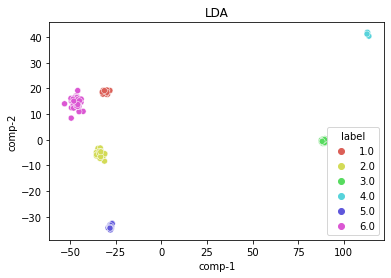

In [7]:
#Code - raw data resized (using some part of the data, first 265 elements from each array)
'''
dataset['raw_travel_time_time'] = dataset['travel_time_time'].to_numpy().flatten()
data = dataset['raw_travel_time_time']
print(data)
'''

# Aggregated data as feature
dataset['raw_travel_time'] = dataset['travel_time'].to_numpy().flatten()
data = dataset['raw_travel_time'][:]

i = 0
final_data = np.zeros((np.size(data), np.size(data[0])))
while i < np.size(data):
    temp = []
    temp = np.array(data[i][:265]).reshape(-1,1)  # resize here !!! (currently set to 0-264)
    #print(len(temp))
    if len(temp) < np.size(data[0]):
        add1 = temp #np.array(data[i][:])
        add2 = np.zeros((np.size(data[0])-len(temp),1))
        #print(add1)
        final_data[i,:] = np.concatenate((add1.reshape(-1,),add2.reshape(-1,)))
    else:
        final_data[i,:] = temp.reshape(-1,)
    i += 1


data = np.array(final_data)
X = np.stack(np.array(data))
X[np.isnan(X)] = 0
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, dataset['label']).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA")

#Answer
The image above represents the six classes of the raw data -- Whent the classification is performed using only the first 265 elemnts from eah array, the classes can be distinguished from each other


QUESTION 2: The travel time of a day have an aggregation of one minute. Is this time aggregation of the dataset necessary? Or can you aggregate the data further in time for the classification? 

[Text(0.5, 1.0, 'LDA')]

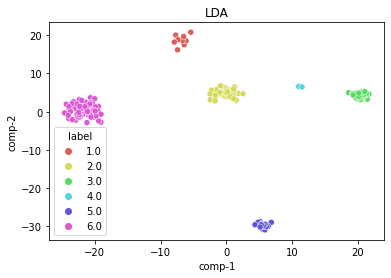

In [8]:
#Code
#Code - raw data resized using cv2
'''
dataset['raw_travel_time_time'] = dataset['travel_time_time'].to_numpy().flatten()
data = dataset['raw_travel_time_time']
print(data)
'''

# Aggregated data as feature
dataset['raw_travel_time'] = dataset['travel_time'].to_numpy().flatten()
data = dataset['raw_travel_time'][:]

i = 0
shape = 250  # resize here !!!
final_data = np.zeros((np.size(data), shape)) 
while i < np.size(data):
    temp = []
    temp = np.array(data[i][:]).reshape(-1,1)  
    temp = cv2.resize(temp, (1,shape)) 
    #print((np.shape(temp)))
    #print(temp)
    if len(temp) < shape:
        add1 = temp #np.array(data[i][:])
        add2 = np.zeros((shape-len(temp),1))
        print(np.shape(add1))
        final_data[i,:] = np.concatenate((add1.reshape(-1,),add2.reshape(-1,)))
    else:
        final_data[i,:] = temp.reshape(-1,)
    i += 1


data = np.array(final_data)
X = np.stack(np.array(data))
X[np.isnan(X)] = 0
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, dataset['label']).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA")

#Answer

The image above represents the classification of aggregated data done using cv2 library -- If the data is reshaped to size 250, the classification looks good.


[Text(0.5, 1.0, 'LDA')]

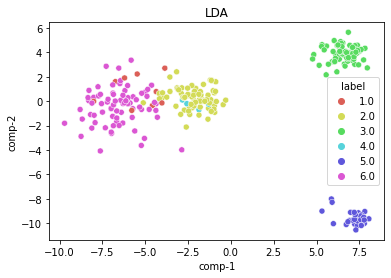

In [9]:
#Code - raw data resized using cv2
'''
dataset['raw_travel_time_time'] = dataset['travel_time_time'].to_numpy().flatten()
data = dataset['raw_travel_time_time']
print(data)
'''

# Aggregated data as feature
dataset['raw_travel_time'] = dataset['travel_time'].to_numpy().flatten()
data = dataset['raw_travel_time'][:]

i = 0
shape = 500  # resize here !!!
final_data = np.zeros((np.size(data), shape)) 
while i < np.size(data):
    temp = []
    temp = np.array(data[i][:]).reshape(-1,1)  
    temp = cv2.resize(temp, (1,shape)) 
    #print((np.shape(temp)))
    #print(temp)
    if len(temp) < shape:
        add1 = temp #np.array(data[i][:])
        add2 = np.zeros((shape-len(temp),1))
        print(np.shape(add1))
        final_data[i,:] = np.concatenate((add1.reshape(-1,),add2.reshape(-1,)))
    else:
        final_data[i,:] = temp.reshape(-1,)
    i += 1


data = np.array(final_data)
X = np.stack(np.array(data))
X[np.isnan(X)] = 0
lda = LinearDiscriminantAnalysis(n_components=2)
X_r = lda.fit(X, dataset['label']).transform(X)
dataset["comp-1"] = X_r[:,0]
dataset["comp-2"] = X_r[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=dataset['label'],
                palette=sns.color_palette("hls", 6),
                data=dataset).set(title="LDA")

The image above represents the classification of aggregated data done using cv2 library -- If the data is reshaped to size 500, the classes 1, 6 and 2, 4 are indistinguishale


QUESTION 3: Does the aggregated travel time data sufficient to distinguish between the six classes. 

#Answer
From the results shown in the cells above, it can be observed that, aggregating the raw data further in time does not show good classification.
On the other hand, if the data is resized to lesser number of elements, the classification looks good

## Bonus Question - High level features

QUESTION 4: Extract high-level features from the travel time dataset using any method or detector. Visualise the output of the detector with an example travel time vector.

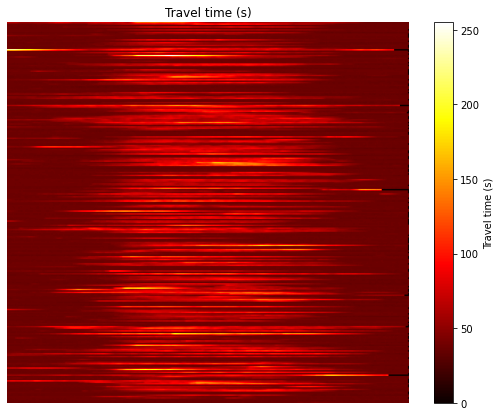

AttributeError: module 'cv2' has no attribute 'SIFT_create'

In [11]:
#Code
dataset['raw_travel_time'] = dataset['travel_time'].to_numpy().flatten()
data = dataset['raw_travel_time'][:]

i = 0
final_data = np.zeros((np.size(data), np.size(data[0])))
while i < np.size(data):
    temp = []
    temp = np.array(data[i][:]).reshape(-1,1)
    #print(len(temp))
    if len(temp) < np.size(data[0]):
        add1 = temp #np.array(data[i][:])
        add2 = np.zeros((np.size(data[0])-len(temp),1))
        #print(add1)
        final_data[i,:] = np.concatenate((add1.reshape(-1,),add2.reshape(-1,)))
    else:
        final_data[i,:] = temp.reshape(-1,)
    i += 1

final_data = (final_data - np.min(final_data)) * 255 / np.max(final_data)
final_data = final_data.astype(np.uint8)

fig = plt.figure(figsize=(9,7))
im = plt.imshow(final_data, cmap=plt.get_cmap('hot'), aspect="auto", vmin=0)
cbar = plt.colorbar(im)
cbar.set_label('Travel time (s)', rotation=90)
plt.axis('off')
plt.title('Travel time (s)')
plt.show()


# Extracting the features using SIFT
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(final_data, None)
sift_image = cv2.drawKeypoints(final_data, keypoints, final_data)

fig = plt.figure(figsize=(9,7))
im = plt.imshow(sift_image, cmap=plt.get_cmap('gray'), aspect="auto", vmin=0)
cbar = plt.colorbar(im)
cbar.set_label('Travel time (s)', rotation=90)
plt.axis('off')
plt.title('Travel time (s)')
plt.show()

#Answer

QUESTION 5: Is the high-level features sufficient to distinguish between the six classes. 

In [7]:
#Code

#Answer

According to the figure shown above, the SIFT algorithm could only detect two features among the six features.


## Task 2 - Probablistic Classifier

QUESTION 6: Divide the dataset into test, train and validation dataset. Build a logistic classifier for the dataset. Use leave-one-out validation strategy for the classifier. Justify the parameter selection

In [8]:
#Code


#Answer

QUESTION 7: Evaluate the classification results with atleast 2 metrics. Justify your choice of metric.  

In [9]:
#Code

#Answer

QUESTION 8: Comment on the statistics of the probabilities in majority and minority classes

In [10]:
#Code

#Answer

## Task 3 - Random Forest Classifier

QUESTION 9: Build a random forest classifier for the dataset. Use k-fold validation strategy for the classifier

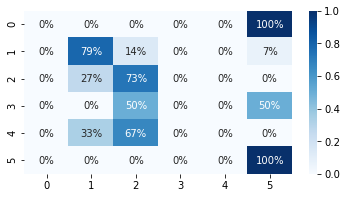

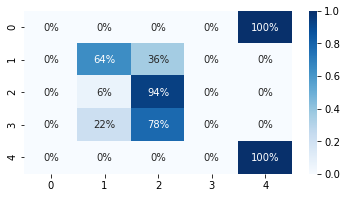

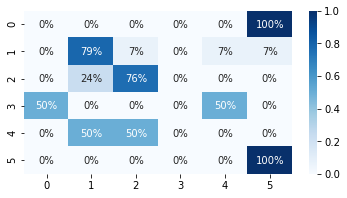

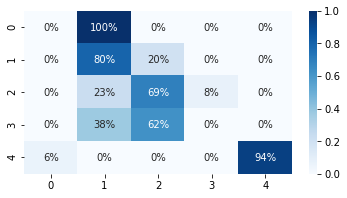

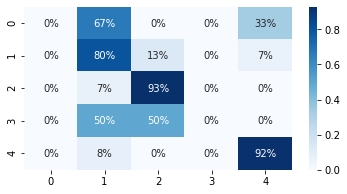

In [3]:
#Code
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import KFold




def resize_features(speed):
  return cv2.resize(speed, (50,50)).flatten()

def show_conf_matrix(y_true, y_pred):
    logreg_conf = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6, 3))
    sns.heatmap(logreg_conf, annot=True, fmt='.0%', cmap='Blues')
    plt.show()


dataset['resize_speed'] = dataset['speed'].apply(resize_features)
X = np.stack(dataset['resize_speed'])
Y = dataset['label']

clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)
kf = KFold(n_splits=5, random_state=None) 

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index] 
    Y_train, Y_test = Y[train_index], Y[test_index]
    clf.fit(X_train, Y_train)
    Ypred_test = clf.predict(X_test)
    show_conf_matrix(Y_test, Ypred_test)


#Answer

QUESTION 10: Conduct a sensitivity analysis of atleast two parameters of the random forest decision trees. Note: You dont need to find the optimal parameters but should conduct a sensitivity analysis.

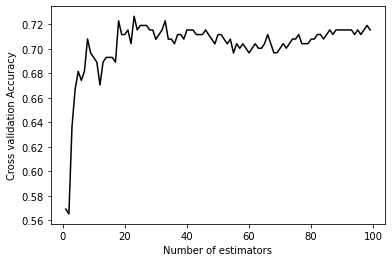

In [39]:
#Code
acc=[]
num=[]
for i in range(1,100):
    clf = RandomForestClassifier(n_estimators=i, max_depth=100, random_state=0)
    kf = KFold(n_splits=5, random_state=None) 
    accuracy_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        Ypred_test = clf.predict(X_test)
        accuracy_scores.append(accuracy_score(Y_test, Ypred_test))
    acc.append(np.mean(accuracy_scores))
    num.append(i)
plt.plot(num,acc ,'k')
plt.xlabel('Number of estimators')
plt.ylabel('Cross validation Accuracy')
plt.show()

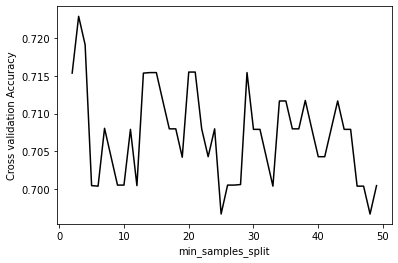

In [43]:
acc=[]
num=[]
for i in range(2,50):
    clf = RandomForestClassifier(n_estimators=100, max_depth=100,min_samples_split=i, random_state=0)
    kf = KFold(n_splits=5, random_state=None) 
    accuracy_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        Ypred_test = clf.predict(X_test)
        accuracy_scores.append(accuracy_score(Y_test, Ypred_test))
    acc.append(np.mean(accuracy_scores))
    num.append(i)
plt.plot(num,acc ,'k')
plt.xlabel('min_samples_split')
plt.ylabel('Cross validation Accuracy')
plt.show()

#Answer

QUESTION 11: Analyse one of the pattern that is wrongly classified and explain why you think it is wrongly classified?

Text(0.5, 1.0, 'Travel Time')

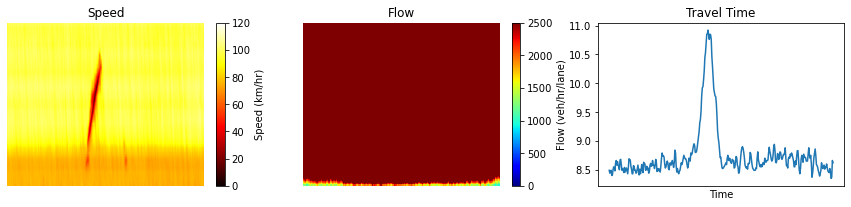

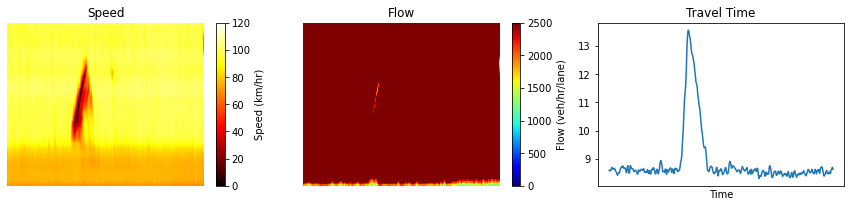

In [4]:
#Code
#Code
#Reading the input and some visualisation code
dataset = pd.read_pickle('Assignment3_dataset_october')
fig, ax = plt.subplots(1,3, figsize=(15,3))
index = 85

im = ax[0].imshow(dataset.iloc[index].speed, cmap=plt.get_cmap('hot'), aspect="auto", vmin=0, vmax=120)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Speed (km/hr)', rotation=90)
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[0].axis('off')
ax[0].set_title('Speed')

im = ax[1].imshow(dataset.iloc[index].flow, cmap=plt.get_cmap('jet'), aspect="auto", vmin=0, vmax=2500)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Flow (veh/hr/lane)', rotation=90)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[1].axis('off')
ax[1].set_title('Flow')

im = ax[2].plot(dataset.iloc[index].travel_time_time, dataset.iloc[index].travel_time)
ax[2].set_xticks([])
ax[2].set_xlabel('Time')
ax[2].set_title('Travel Time')

#Code
#Reading the input and some visualisation code
dataset = pd.read_pickle('Assignment3_dataset_october')
fig, ax = plt.subplots(1,3, figsize=(15,3))
index = 250

im = ax[0].imshow(dataset.iloc[index].speed, cmap=plt.get_cmap('hot'), aspect="auto", vmin=0, vmax=120)
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label('Speed (km/hr)', rotation=90)
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[0].axis('off')
ax[0].set_title('Speed')

im = ax[1].imshow(dataset.iloc[index].flow, cmap=plt.get_cmap('jet'), aspect="auto", vmin=0, vmax=2500)
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label('Flow (veh/hr/lane)', rotation=90)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
ax[1].axis('off')
ax[1].set_title('Flow')

im = ax[2].plot(dataset.iloc[index].travel_time_time, dataset.iloc[index].travel_time)
ax[2].set_xticks([])
ax[2].set_xlabel('Time')
ax[2].set_title('Travel Time')

#Answer

As we can see in the bottom image, a similar situation was labeled as '1', which may influenced the classifier to also label the event as '1' as the bottom image was in the training dataset. Therefore it is reasonable to assume that there is an error in the labelling and not so much in the classifier itself. This may be due to manually labeling the data.

## Task 4 - Feature Importance

QUESTION 12: Visualise one of the random tree. Comment on the tree structure

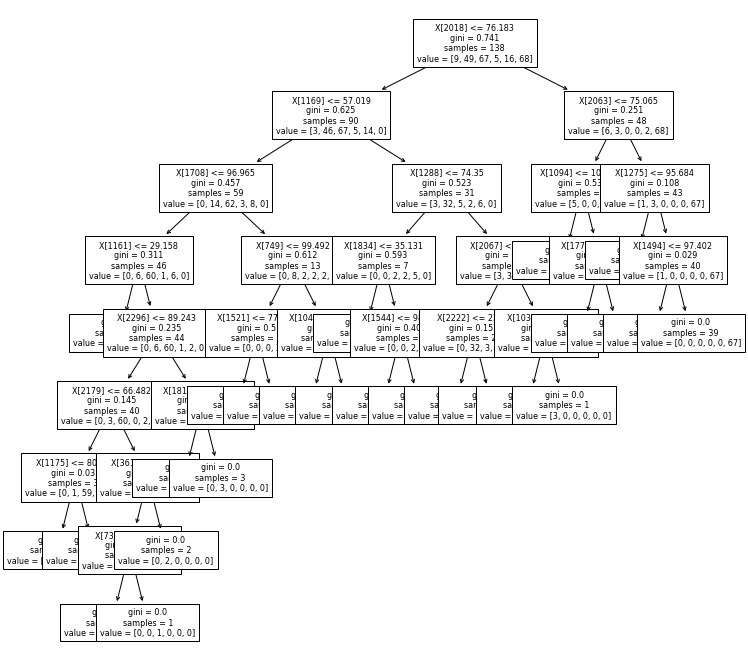

In [5]:
#Code
plt.figure(figsize=(12,12))
tree.plot_tree(clf.estimators_[0], fontsize=8) 
plt.show()


#Answer
In many of the branches the gini score is 0.0. This is really bad since that branch does not provide any information, and is therefore not useful and the samples are allocated there. On the other hand the branches with reasonable gini scores provide valuable information



QUESTION 13: Analyse the random forest feature importance and comment on the findings.

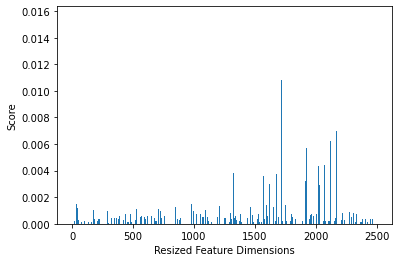

In [46]:
#Code
X_train, _X, Y_train, _Y = train_test_split(X, Y, train_size=0.5, stratify=Y, random_state=rand_seed)
X_validate, X_test, Y_validate, Y_test = train_test_split(_X, _Y, train_size=0.5, stratify=_Y, random_state=rand_seed)
clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(X_train, Y_train)
Ypred_test = clf.predict(X_test)
importance = clf.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Resized Feature Dimensions')
plt.ylabel('Score')
plt.show()

#Answer

## Task 5 - Reflection

QUESTION 14: Given your analysis of the data, do you consider this a supervised classification problem or do you think it can also be solved as a unsupervised learning problem. (No need of coding. Just reflect!)

#Answer

1. It depends on the problem statement: if we are content with just clustering the data and find 6 distinct groups for example, we can say it is an unsupervised problem. However, if we really want to find out what is happening, for example if we want to know if the event was a small traffic error or a huge fire, we would by definition need to make it a supervised classification problem.

2. The only exception being that if we train on unlabeled data and we generate clusters, we could in principle manually label the clusters afterwards and thereby technically make it an unsupervised learning problem because we trained on unlabeled data.